<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-3--disease-outbreaks/03_case_study_disease_outbreaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Case Study: disease outbreaks

This navigation paradigm perfectly encapsulates the standard data science process. As
data scientists, we are offered raw observations. We algorithmically analyze that data.
Then, we visualize the results to make critical decisions. Thus, data science and location
analysis are linked. That link has only grown stronger through the centuries.

Hedge funds study satellite photos of farmlands to make bets on the
global soybean market. Transport-service providers analyze vast traffic patterns to efficiently
route fleets of cars. Epidemiologists process newspaper data to monitor the
global spread of disease.

In this notebook, we explore a variety of techniques for analyzing and visualizing geographic
locations. We begin with the simple task of calculating the distance between
two geographic points.

##Setup

Reference:
https://colab.research.google.com/github/astg606/py_materials/blob/master/visualization/introduction_cartopy.ipynb

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install geonamescache
!pip install Unidecode

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import defaultdict
import itertools
import re
import numpy as np
import pandas as pd
from scipy import stats
from math import cos, sin, asin
from math import pi

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import euclidean
from sklearn.datasets import make_circles

from geonamescache import GeonamesCache

from unidecode import unidecode

import cartopy
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree
from cartopy.crs import LambertConformal

##The great-circle distance

We can compute the great-circle distance given a sphere and two points on that
sphere. 

Any point on the sphere’s surface can be represented using spherical coordinates
x and y, where x and y measure the angles of the point relative to the x-axis and y-axis.

In [ ]:
# Defining a great-circle distance function
def great_circle_distance(x1, y1, x2, y2):
  # Computes the angular difference between the two pairs of spherical coordinates
  delta_x, delta_y = x2 - x1, y2 - y1
  haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2), sin(delta_y / 2) ** 2])
  return 2 * asin(haversin ** .5)

Let’s calculate the greatcircle
distance between two points that lie 180 degrees apart relative to both the x-axis
and the y-axis.

In [ ]:
# Computing the great-circle distance
distance = great_circle_distance(0, 0, 0, pi)
print(f"The distance equals {distance} units.")

The distance equals 3.141592653589793 units.


That value is the longest possible distance we can travel between two spherical
points. 

This is akin to traveling between the North and South Poles of any planet.

Let’s begin by recording the known coordinates of each pole.

In [ ]:
# Defining the coordinates of Earth’s poles
latitude_north, longitude_north = (90.0, 0)
latitude_south, longitude_south = (-90.0, 0)

In [ ]:
# Computing the great-circle distance between poles
to_radians = np.radians([latitude_north, longitude_north, latitude_south, longitude_south])
distance = great_circle_distance(*to_radians.tolist())
print(f"The unit-circle distance between poles equals {distance} units.")

The unit-circle distance between poles equals 3.141592653589793 units.


Now, let’s measure the
distance between two poles here on Earth. 

The radius of Earth is not 1 hypothetical
unit but rather 3956 actual miles, so we must multiply distance by 3956 to obtain a
terrestrial measurement.

In [ ]:
# Computing the travel distance between Earth’s poles
earth_distance = 3956 * distance
print(f"The distance between poles equals {earth_distance} miles.")

The distance between poles equals 12428.14053760122 miles.


In [ ]:
# Defining a travel distance function
def travel_distance(lat1, lon1, lat2, lon2):
  to_radians = np.radians([lat1, lon1, lat2, lon2])
  return 3956 * great_circle_distance(*to_radians.tolist())

assert travel_distance(90, 0, -90, 0) == earth_distance

As discussed, we can pass such metrics into
the DBSCAN clustering algorithm, so we can use `travel_distance` to cluster locations based on their spatial distributions. 

Then we can visually validate the clusters by
plotting the locations on a map. This map plot can be executed using the external `Cartopy` visualization library.

##Plotting maps using Cartopy

A geographic map is a 2D representation of a 3D surface on a globe. Flattening the
spherical globe is carried out using a process called projection. 

There are many different
types of map projections: the simplest involves superimposing the globe on an
unrolled cylinder, which yields a 2D map whose `(x, y)` coordinates perfectly correspond
with longitude and latitude.

This technique is called the equidistant cylindrical projection or plate carrée projection.

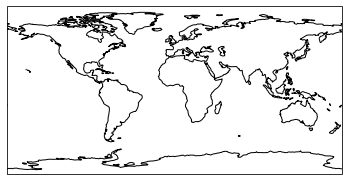

In [ ]:
# Visualizing the Earth using Cartopy
plt.axes(projection=PlateCarree()).coastlines()
plt.show()

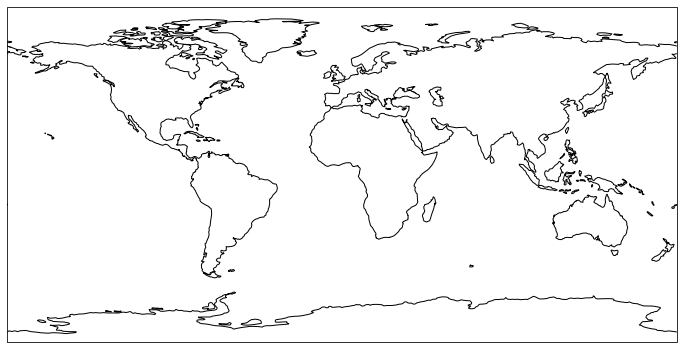

In [ ]:
# Visualizing a larger map of the Earth
plt.figure(figsize=(12, 8))
plt.axes(projection=PlateCarree()).coastlines()
plt.show()

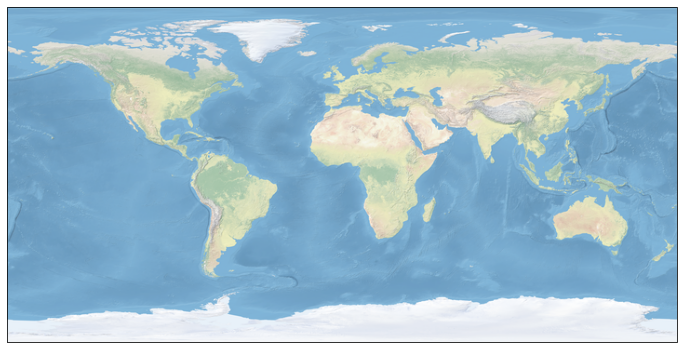

In [ ]:
# Coloring a map of the Earth
plt.figure(figsize=(12, 8))
plt.axes(projection=PlateCarree()).stock_img()
plt.show()

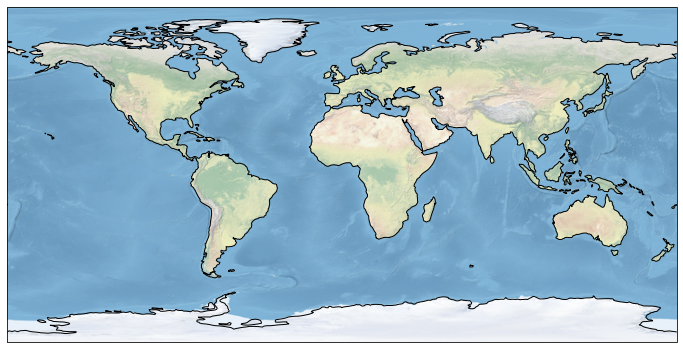

In [ ]:
# Plotting coastlines together with map colors
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.stock_img()
plt.show()

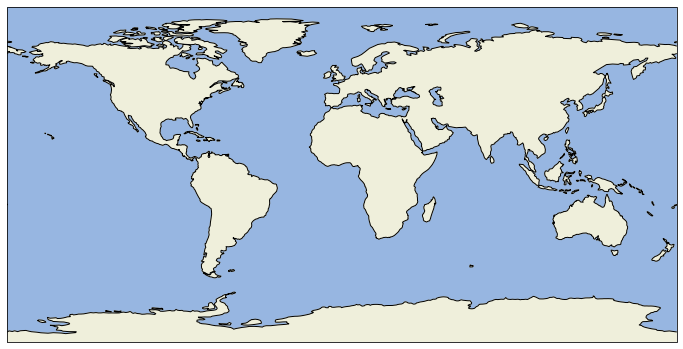

In [ ]:
# Adding colors with the feature module
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
plt.show()

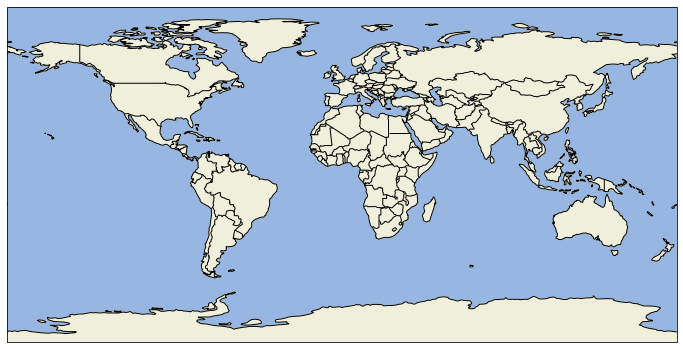

In [ ]:
# Adding national borders to the plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
plt.show()

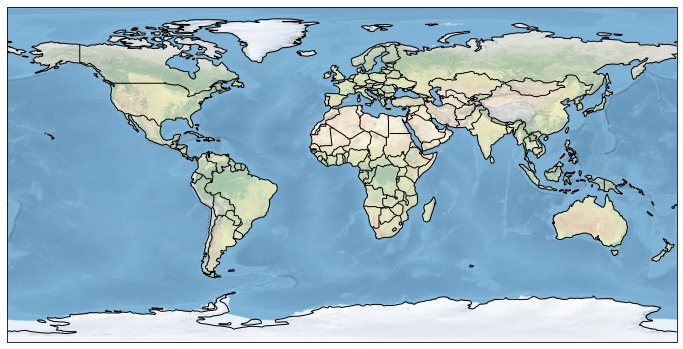

In [ ]:
# Adding national borders to the plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.stock_img()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
plt.show()

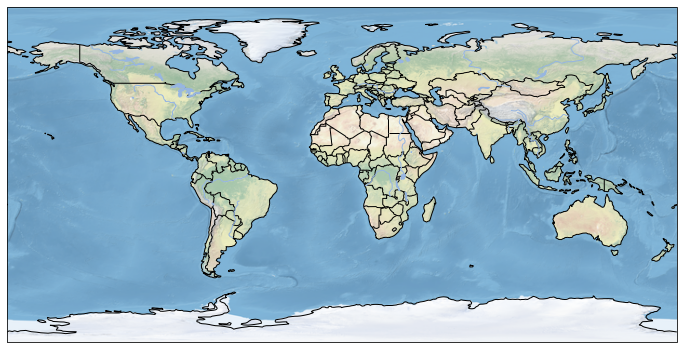

In [ ]:
# Adding national borders with river to the plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.RIVERS)
plt.show()

Suppose we are given a list of locations defined by pairs of latitudes and longitudes.
We can plot these locations on a global map as a standard scatter plot by calling `ax.scatter(longitudes, latitudes)`.

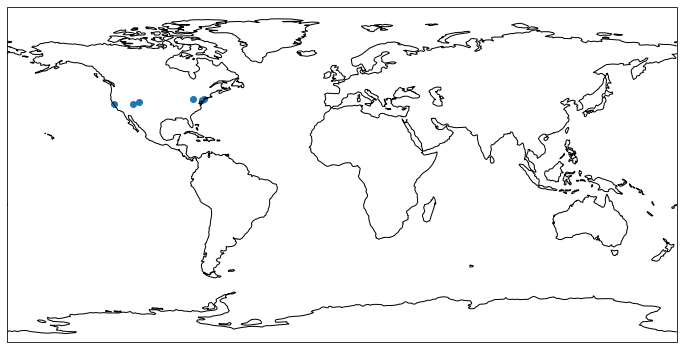

In [ ]:
# Plotting coordinates on a map
coordinates = [
  (39.9526, -75.1652), (37.7749, -122.4194),
  (40.4406, -79.9959), (38.6807, -108.9769),
  (37.8716, -112.2727), (40.7831, -73.9712)             
]
latitudes, longitudes = np.array(coordinates).T

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.scatter(longitudes, latitudes)
ax.set_global()
ax.coastlines()
plt.show()

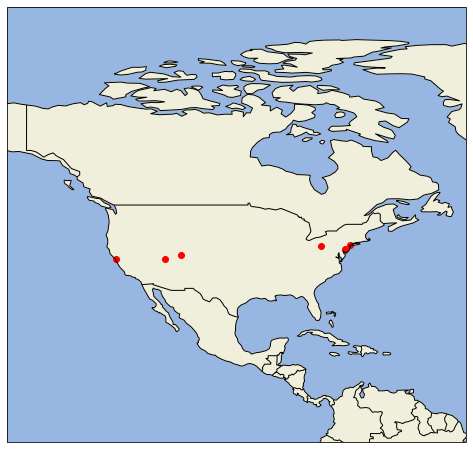

In [ ]:
# Plotting North American coordinates
def add_map_features(ax):
  ax.coastlines()
  ax.add_feature(cartopy.feature.BORDERS)
  ax.add_feature(cartopy.feature.OCEAN)
  ax.add_feature(cartopy.feature.LAND)

# The North American extent occurs between –145 and –50 degrees longitude and between 0 and 90 degrees latitude.
north_america_extent = (-145, -50, 0, 90)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.set_extent(north_america_extent)
ax.scatter(longitudes, latitudes, color="r")
add_map_features(ax)
plt.show()

We successfully zoomed in on North America. Now we’ll zoom in further, to the
United States.

Unfortunately, the plate carrée projection is insufficient for this purpose:
that technique distorts the map if we zoom in too close on any country.

Instead, we will rely on the Lambert conformal conic projection. In this projection, a
cone is placed on top of the spherical Earth. The cone’s circular base covers the
region we intend to map. 

Then, coordinates in the region are projected onto the surface
of the cone.

Finally, the cone is unrolled to create a 2D map. However, that map’s
2D coordinates don’t directly equal longitude and latitude.

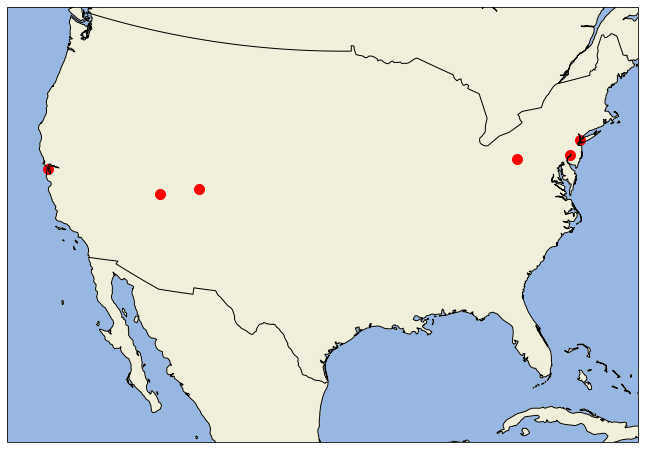

In [ ]:
# Plotting US coordinates

# The US extent occurs between –120 and –75 degrees longitude and between 20 and 50 degrees latitude
us_extent = (-120, -75, 20, 50)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=LambertConformal())
ax.set_extent(us_extent)
# Transforms longitudes and latitudes from PlateCarree-compatible coordinates
ax.scatter(longitudes, latitudes, color="r", transform=PlateCarree(), s=100)
add_map_features(ax)
plt.show()

Our map of the United States is looking a little sparse. 

Let’s add state borders.

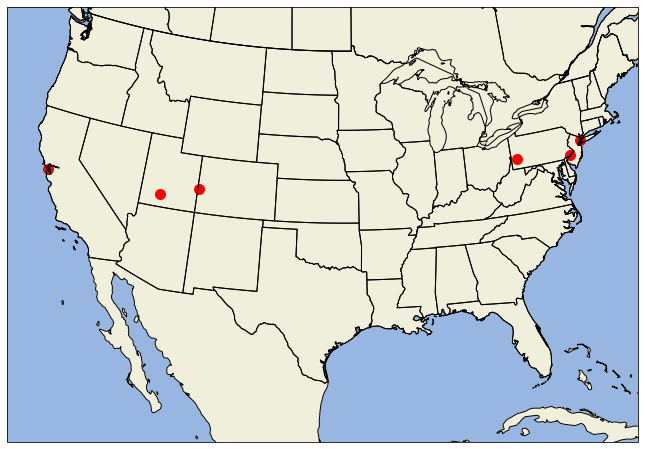

In [ ]:
# Plotting a US map including state borders
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=LambertConformal())
ax.set_extent(us_extent)
ax.scatter(longitudes, latitudes, color="r", transform=PlateCarree(), s=100)
add_map_features(ax)
ax.add_feature(cartopy.feature.STATES)
plt.show()

##Location tracking using GeoNamesCache

The GeoNames database (http://geonames.org) is an excellent resource for obtaining
geographic data. GeoNames contains over 11 million place names spanning all
the countries in the world. In addition, GeoNames stores valuable information such as
latitude and longitude. 

Thus, we can use the database to determine the precise geographic
locations of cities and countries discovered in text.

GeoNamesCache is designed to efficiently retrieve data about continents, countries,
cities, and US counties and states.

In [ ]:
# Initializing a GeonamesCache object
gc = GeonamesCache()

In [ ]:
# Fetching all seven continents from GeoNamesCache
continents = gc.get_continents()
print(continents.keys())

dict_keys(['AF', 'AS', 'EU', 'NA', 'OC', 'SA', 'AN'])


In [ ]:
# Fetching North America from GeoNamesCache
north_america = continents["NA"]
print(north_america.keys())

dict_keys(['lng', 'geonameId', 'timezone', 'bbox', 'toponymName', 'asciiName', 'astergdem', 'fcl', 'population', 'wikipediaURL', 'adminName5', 'srtm3', 'adminName4', 'adminName3', 'alternateNames', 'cc2', 'adminName2', 'name', 'fclName', 'fcodeName', 'adminName1', 'lat', 'fcode', 'continentCode'])


In [ ]:
# Printing North America’s naming schemes
for name_key in ["name", "asciiName", "toponymName"]:
  print(north_america[name_key])

North America
North America
North America


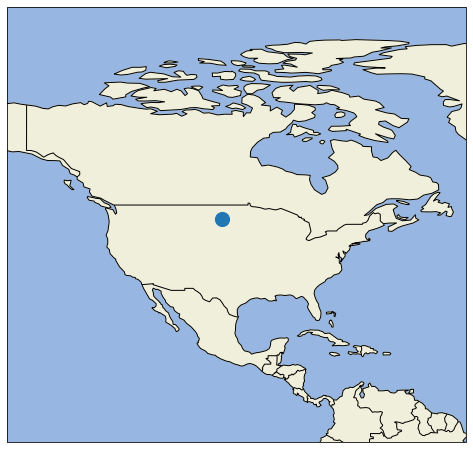

In [ ]:
# Mapping North America’s central coordinates
latitude = float(north_america["lat"])
longitude = float(north_america["lng"])

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.set_extent(north_america_extent)
ax.scatter([longitude], [latitude], s=200)
add_map_features(ax)
plt.show()

###Accessing country information

The ability to access continental data is useful, although our primary concern is analyzing
cities and countries.

In [ ]:
# Fetching US data from GeoNamesCache
countries = gc.get_countries()
num_countries = len(countries)
print(f"GeonamesCache holds data for {num_countries} countries.")

us_data = countries["US"]
print(f"The following data pertains to the United States:")
print(us_data)

GeonamesCache holds data for 252 countries.
The following data pertains to the United States:
{'geonameid': 6252001, 'name': 'United States', 'iso': 'US', 'iso3': 'USA', 'isonumeric': 840, 'fips': 'US', 'continentcode': 'NA', 'capital': 'Washington', 'areakm2': 9629091, 'population': 310232863, 'tld': '.us', 'currencycode': 'USD', 'currencyname': 'Dollar', 'phone': '1', 'postalcoderegex': '^\\d{5}(-\\d{4})?$', 'languages': 'en-US,es-US,haw,fr', 'neighbours': 'CA,MX,CU'}


In [ ]:
in_data = countries["IN"]
print(f"The following data pertains to India:")
print(in_data)

The following data pertains to India:
{'geonameid': 1269750, 'name': 'India', 'iso': 'IN', 'iso3': 'IND', 'isonumeric': 356, 'fips': 'IN', 'continentcode': 'AS', 'capital': 'New Delhi', 'areakm2': 3287590, 'population': 1173108018, 'tld': '.in', 'currencycode': 'INR', 'currencyname': 'Rupee', 'phone': '91', 'postalcoderegex': '^(\\d{6})$', 'languages': 'en-IN,hi,bn,te,mr,ta,ur,gu,kn,ml,or,pa,as,bh,sat,ks,ne,sd,kok,doi,mni,sit,sa,fr,lus,inc', 'neighbours': 'CN,NP,MM,BT,PK,BD'}


In [ ]:
# Fetching neighboring countries
us_neighbors = us_data["neighbours"]
for neighbor_code in us_neighbors.split(","):
  print(countries[neighbor_code]["name"])

Canada
Mexico
Cuba


In [ ]:
in_neighbors = in_data["neighbours"]
for neighbor_code in in_neighbors.split(","):
  print(countries[neighbor_code]["name"])

China
Nepal
Myanmar
Bhutan
Pakistan
Bangladesh


In [ ]:
# Fetching countries by name
result = gc.get_countries_by_names()["United States"]
assert result == countries["US"]

In [ ]:
result = gc.get_countries_by_names()["India"]
assert result == countries["IN"]

###Accessing city information

Now, let’s turn our attention to analyzing cities.

In [ ]:
# Fetching cities from GeoNamesCache
cities = gc.get_cities()
num_cities = len(cities)
print(f"GeoNamesCache holds data for {num_cities} total cities")

city_id = list(cities.keys())[0]
print(cities[city_id])

GeoNamesCache holds data for 25286 total cities
{'geonameid': 3041563, 'name': 'Andorra la Vella', 'latitude': 42.50779, 'longitude': 1.52109, 'countrycode': 'AD', 'population': 20430, 'timezone': 'Europe/Andorra', 'admin1code': '07', 'alternatenames': ['ALV', 'Ando-la-Vyey', 'Andora', 'Andora la Vela', 'Andora la Velja', "Andora lja Vehl'ja", 'Andoro Malnova', 'Andorra', 'Andorra Tuan', 'Andorra a Vella', 'Andorra la Biella', 'Andorra la Vella', 'Andorra la Vielha', 'Andorra-a-Velha', "Andorra-la-Vel'ja", 'Andorra-la-Vielye', 'Andorre-la-Vieille', 'Andò-la-Vyèy', 'Andòrra la Vièlha', 'an dao er cheng', 'andolalabeya', 'andwra la fyla', 'Ανδόρρα', 'Андора ла Веля', 'Андора ла Веља', 'Андора ля Вэлья', 'Андорра-ла-Велья', 'אנדורה לה וולה', 'أندورا لا فيلا', 'አንዶራ ላ ቬላ', 'アンドラ・ラ・ヴェリャ', '安道爾城', '안도라라베야']}


In [ ]:
# Fetching US cities from GeoNamesCache
us_cities = [city for city in cities.values() if city["countrycode"] == "US"]
num_us_cities = len(us_cities)
print(f"GeoNamesCache holds data for {num_us_cities} US cities.")

GeoNamesCache holds data for 3264 US cities.


In [ ]:
in_cities = [city for city in cities.values() if city["countrycode"] == "IN"]
num_in_cities = len(in_cities)
print(f"GeoNamesCache holds data for {num_in_cities} India cities.")

GeoNamesCache holds data for 2468 India cities.


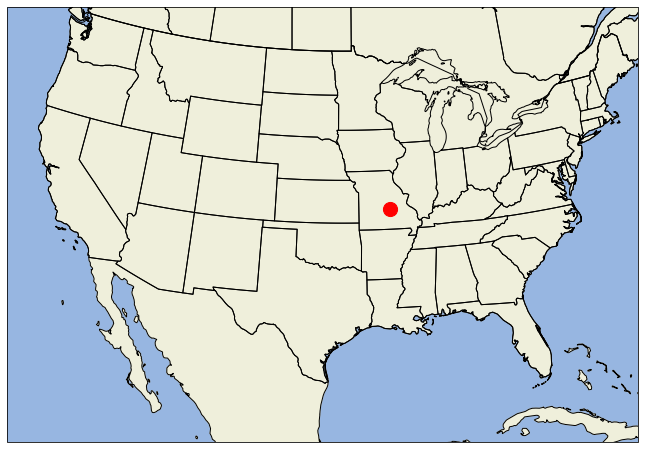

In [ ]:
# Approximating US central coordinates
center_lat = np.mean([city["latitude"] for city in us_cities])
center_lon = np.mean([city["longitude"] for city in us_cities])

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=LambertConformal())
ax.set_extent(us_extent)
ax.scatter([center_lon], [center_lat], color="r", transform=PlateCarree(), s=200)
ax.add_feature(cartopy.feature.STATES)
add_map_features(ax)
plt.show()

In [ ]:
# Fetching cities by name
matched_cities_by_name = gc.get_cities_by_name("Philadelphia")
print(matched_cities_by_name)

[{'4560349': {'geonameid': 4560349, 'name': 'Philadelphia', 'latitude': 39.95233, 'longitude': -75.16379, 'countrycode': 'US', 'population': 1567442, 'timezone': 'America/New_York', 'admin1code': 'PA', 'alternatenames': ['Coaquannock', 'Fi-sang', 'Fi-sàng', "Filadehl'fija", "Filadel'fi", "Filadel'fij", "Filadel'fija", 'Filadelfi', 'Filadelfia', 'Filadelfiae', 'Filadelfie', 'Filadelfii', 'Filadelfija', 'Filadelfijo', 'Filadelfio', 'Filadelfiya', 'Filadelfiye', 'Filadelfiä', 'Filadèlfia', 'Filadélfia', 'Filadélfiye', 'Ga-na-ta-jen-go-na', 'PHL', 'Phila', 'Philadelpheia', 'Philadelphia', 'Philadelphie', 'Philly', 'Quequenakee', 'Tsi wahswen:to Tekahso:ken', 'Tsi wahswèn:to Tekahsó:ken', 'fei cheng', 'fi la delfeiy', "filadailafi'a", 'firaderufia', 'flaڈylfya', 'fyladlfya', 'fyladlfya  pnsylwanya', 'philadelaphiya', 'philadelphiya', 'piladelpia', 'pilatelpiya', 'pilladelpia', 'pyldlpyh', 'Φιλαδέλφεια', 'Филаделфиа', 'Филаделфия', 'Филаделфија', 'Филадельфи', 'Филадельфий', 'Филадельфия', '

In [ ]:
# Fetching multiple cities with a shared name
matched_cities_list = gc.get_cities_by_name("San Francisco")

for i, san_francisco in enumerate(matched_cities_list):
  city_info = list(san_francisco.values())[0]
  country_code = city_info["countrycode"]
  country = countries[country_code]["name"]
  print(f"The San Francisco at index {i} is located in {country}")

The San Francisco at index 0 is located in Argentina
The San Francisco at index 1 is located in Costa Rica
The San Francisco at index 2 is located in Philippines
The San Francisco at index 3 is located in Philippines
The San Francisco at index 4 is located in El Salvador
The San Francisco at index 5 is located in United States


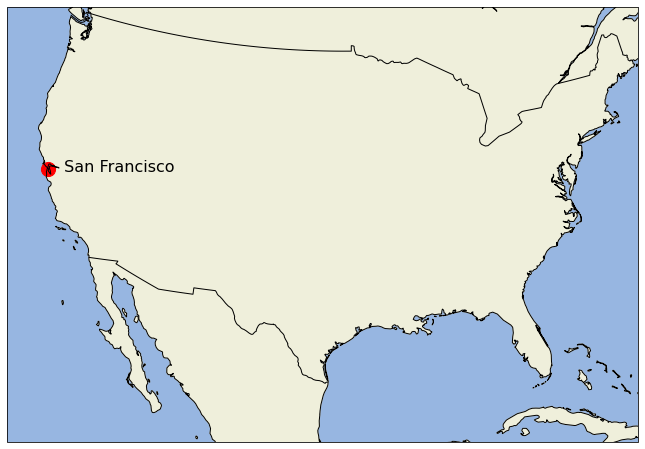

In [ ]:
# Mapping the most populous San Francisco
best_sf = max(gc.get_cities_by_name("San Francisco"), key=lambda x: list(x.values())[0]["population"])
sf_data = list(best_sf.values())[0]
sf_lat = sf_data["latitude"]
sf_lon = sf_data["longitude"]

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=LambertConformal())
ax.set_extent(us_extent)
ax.scatter(sf_lon, sf_lat, color="r", transform=PlateCarree(), s=200)
add_map_features(ax)
ax.text(sf_lon + 1, sf_lat, " San Francisco", fontsize=16, transform=PlateCarree())
plt.show()

###Limitations of the GeoNamesCache

The single name-to-city mapping is particularly problematic due to the presence of
diacritics in city names. 

Diacritics are accent marks that designate the proper pronunciation
of non-English-sounding words.

In [ ]:
# Fetching New York City from GeoNamesCache
for ny_name in ["New York", "New York City"]:
  if not gc.get_cities_by_name(ny_name):
    print(f"{ny_name} is not present in the GeoNamesCache database.")
  else:
    print(f"{ny_name} is present in the GeoNamesCache database.")

New York is not present in the GeoNamesCache database.
New York City is present in the GeoNamesCache database.


In [ ]:
# Fetching accented cities from GeoNamesCache
print(gc.get_cities_by_name(u"Cañon City"))
print(gc.get_cities_by_name(u"Hagåtña"))

[{'5416005': {'geonameid': 5416005, 'name': 'Cañon City', 'latitude': 38.44098, 'longitude': -105.24245, 'countrycode': 'US', 'population': 16400, 'timezone': 'America/Denver', 'admin1code': 'CO', 'alternatenames': ['CNE', 'Canon City', 'Canyon City', 'Cañon City', 'East Canon', 'Kanon Siti', 'Kanono siti', 'Keniun Siti', 'kann syty  klradw', 'kanwn syty', 'kyanana siti', 'Каноно сити', 'Кањон Сити', 'Кениън Сити', 'كانون سيتي', 'کانن سیتی، کلرادو', 'کینن سٹی، کولوراڈو', 'क्यानन सिटी']}}]
[{'4044012': {'geonameid': 4044012, 'name': 'Hagåtña', 'latitude': 13.47567, 'longitude': 144.74886, 'countrycode': 'GU', 'population': 1051, 'timezone': 'Pacific/Guam', 'admin1code': 'AN', 'alternatenames': ['Agadna', 'Agana', 'Agana -1998', 'Agania', 'Aganija', 'Aganja', 'Agano', 'Agaña', 'Aguana', 'Akashi', 'Akashi - JP renamed WW2', 'Ankana', 'City of Ignacio de Agana', 'City of Saint Ignacio de Agana', 'Ciudad de San Ignacio de Agana', 'Hagadna', 'Hagatna', 'Hagåtña', 'Haqatna', 'Jagatna', 'Khaga

In [ ]:
# Counting all accented cities in GeoNamesCache
accented_names = [city["name"] for city in gc.get_cities().values() if city["name"] != unidecode(city["name"])]

num_accented_cities = len(accented_names)

print(f"An example accented city name is {accented_names[0]}")
print(f"{num_accented_cities} cities have accented names")

An example accented city name is Khawr Fakkān
4938 cities have accented names


In [ ]:
# Stripping accents from alternative city names
alternative_names = {unidecode(name): name for name in accented_names}
print(gc.get_cities_by_name(alternative_names["Hagatna"]))

[{'4044012': {'geonameid': 4044012, 'name': 'Hagåtña', 'latitude': 13.47567, 'longitude': 144.74886, 'countrycode': 'GU', 'population': 1051, 'timezone': 'Pacific/Guam', 'admin1code': 'AN', 'alternatenames': ['Agadna', 'Agana', 'Agana -1998', 'Agania', 'Aganija', 'Aganja', 'Agano', 'Agaña', 'Aguana', 'Akashi', 'Akashi - JP renamed WW2', 'Ankana', 'City of Ignacio de Agana', 'City of Saint Ignacio de Agana', 'Ciudad de San Ignacio de Agana', 'Hagadna', 'Hagatna', 'Hagåtña', 'Haqatna', 'Jagatna', 'Khagatna', 'San Ignacio de Agana *', "Ville d'Agana", "Vjoska Agan'ja", 'a jia ni ya', 'akatna', 'ha katya', 'hagania', 'hagasnya', 'hagatna', 'hagatnya', 'haghatnya', "hegatn'ya", 'Αγκάνα', 'Вёска Аганья', 'Хагатна', 'Хагатња', 'Հագատնա', 'هاغاتنيا', 'هاگاتنا', 'هاگاتنیا', 'हेगात्न्या', 'அகாத்ன', 'ฮากาตญา', 'ჰაგატნა', 'ハガニア', '阿加尼亚', '하갓냐']}}]


In [ ]:
# Finding accent-free city names in text
text = "This sentence matches Hagatna"
for key, value in alternative_names.items():
  if key in text:
    print(gc.get_cities_by_name(value))
    break

[{'4044012': {'geonameid': 4044012, 'name': 'Hagåtña', 'latitude': 13.47567, 'longitude': 144.74886, 'countrycode': 'GU', 'population': 1051, 'timezone': 'Pacific/Guam', 'admin1code': 'AN', 'alternatenames': ['Agadna', 'Agana', 'Agana -1998', 'Agania', 'Aganija', 'Aganja', 'Agano', 'Agaña', 'Aguana', 'Akashi', 'Akashi - JP renamed WW2', 'Ankana', 'City of Ignacio de Agana', 'City of Saint Ignacio de Agana', 'Ciudad de San Ignacio de Agana', 'Hagadna', 'Hagatna', 'Hagåtña', 'Haqatna', 'Jagatna', 'Khagatna', 'San Ignacio de Agana *', "Ville d'Agana", "Vjoska Agan'ja", 'a jia ni ya', 'akatna', 'ha katya', 'hagania', 'hagasnya', 'hagatna', 'hagatnya', 'haghatnya', "hegatn'ya", 'Αγκάνα', 'Вёска Аганья', 'Хагатна', 'Хагатња', 'Հագատնա', 'هاغاتنيا', 'هاگاتنا', 'هاگاتنیا', 'हेगात्न्या', 'அகாத்ன', 'ฮากาตญา', 'ჰაგატნა', 'ハガニア', '阿加尼亚', '하갓냐']}}]


GeoNamesCache allows us to easily track locations along with their geographical coordinates.

Using the library, we can also search for mentioned location names within any
inputted text.

##Matching location names in text

In [ ]:
# Basic string matching
assert "Boston" in "Boston Marathon"
assert "Boston Marathon".startswith("Boston")
assert "Boston Marathon".endswith("Boston") == False

In [ ]:
# Basic substring matching errors
assert "in a" in "sin apple"
assert "in a" in "win attached"

In [ ]:
# String matching using regexes
regex = "Boston"
random_text = "Clown Patty"
match = re.search(regex, random_text)
assert match is None

In [ ]:
matchable_text = "Boston Marathon"
match = re.search(regex, matchable_text)
assert match is not None

start, end = match.start(), match.end()
matched_string = matchable_text[start: end]
assert matched_string == "Boston"

In [ ]:
# Case-insensitive matching using regexes
for text in ["BOSTON", "boston", "BoSTOn"]:
  assert re.search(regex, text, flags=re.IGNORECASE) is not None

In [ ]:
# Word boundary matching using regexes
for regex in ["\\bin a\\b", r"\bin a\b"]:
  for text in ["sin apple", "win attached"]:
    assert re.search(regex, text) is None
  text = "Match in a string"
  assert re.search(regex, text) is not None

In [ ]:
# Multicity matching using regexes
regex = r"I visited \b(Boston|Philadelphia|San Francisco)\b yesterday."
assert re.search(regex, "I visited Chicago yesterday.") is None

cities = ["Boston", "Philadelphia", "San Francisco"]
for city in cities:
  assert re.search(regex, f"I visited {city} yesterday.") is not None

In [ ]:
# String matching using compiled regexes
compiled_re = re.compile(regex)
text = "I visited Boston yesterday."
for i in range(1000):
  assert compiled_re.search(text) is not None

Regex matching allows us to find location names in text.